# Cell painting data loading

In this notebook we load the cell painting data and test out some broad phenotype definitions.

In [1]:
# Setup and imports
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Template for loading profiles
profile_uri_template = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
)

# Template for loading negative control normalized profiles -- not working!
negcon_norm_profile_uri_template = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}_normalized_negcon.parquet"
)

In [3]:
# Load metadata
plates = pd.read_csv("datasets/metadata/plate.csv.gz")
wells = pd.read_csv("datasets/metadata/well.csv.gz")
orf = pd.read_csv("datasets/metadata/orf.csv.gz")
crispr = pd.read_csv("datasets/metadata/crispr.csv.gz", dtype={'Metadata_NCBI_Gene_ID': 'str'})
compound = pd.read_csv("datasets/metadata/compound.csv.gz")

In [4]:
plates.Metadata_PlateType.value_counts()

Metadata_PlateType
COMPOUND          1729
ORF                251
CRISPR             148
TARGET2            141
DMSO                77
COMPOUND_EMPTY      20
POSCON8              8
TARGET1              4
Name: count, dtype: int64

Wells (and profiles) are identified by their `Metadata_{Source, Plate, Well}` triple.

We need to attach metadata about the genetic perturbation to each well.

In [5]:
orf

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt
1,JCP2022_900003,ccsbBroad304_00002,ORF005388.1_TRC304.1,pLX_304,NM_001088.3,AANAT,15,9606,aralkylamine N-acetyltransferase,100.0,621.0,trt
2,JCP2022_900004,ccsbBroad304_00003,ORF003876.1_TRC304.1,pLX_304,NM_000663.4,ABAT,18,9606,4-aminobutyrate aminotransferase,100.0,1500.0,trt
3,JCP2022_900005,ccsbBroad304_00007,ORF004679.1_TRC304.1,pLX_304,NM_000018.4,ACADVL,37,9606,acyl-CoA dehydrogenase very long chain,100.0,1965.0,trt
4,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,1584.0,trt
...,...,...,...,...,...,...,...,...,...,...,...,...
15137,JCP2022_915128,ccsbBroad304_99985,ORFC00001.1_TRC304.1,pLX_304,BFP.1,BFP,BFP,CONTROL,Hahn Lab BFP,99.5,717.0,negcon
15138,JCP2022_915129,ccsbBroad304_99988,ORFC00002.1_TRC304.1,pLX_304,HcRed.1,HcRed,HcRed,CONTROL,NaN,NaN,824.0,negcon
15139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,1650.0,negcon
15140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,3204.0,negcon


For ORF perturbations we keep the gene ID, Symbol, and prepend a string to treatment to identify that it's an ORF perturbation

In [6]:
orf_meta = orf[['Metadata_JCP2022', 'Metadata_Symbol', 'Metadata_NCBI_Gene_ID']]
orf_meta['Metadata_Perturbation'] = orf.Metadata_pert_type.apply(lambda x: f'ORF-{x}')
orf_meta

/tmp/ipykernel_3236/3138304948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orf_meta['Metadata_Perturbation'] = orf.Metadata_pert_type.apply(lambda x: f'ORF-{x}')


,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
0,JCP2022_900002,NAT1,9,ORF-trt
1,JCP2022_900003,AANAT,15,ORF-trt
2,JCP2022_900004,ABAT,18,ORF-trt
3,JCP2022_900005,ACADVL,37,ORF-trt
4,JCP2022_900006,ASIC1,41,ORF-trt
...,...,...,...,...
15137,JCP2022_915128,BFP,BFP,ORF-negcon
15138,JCP2022_915129,HcRed,HcRed,ORF-negcon
15139,JCP2022_915130,LUCIFERASE,LUCIFERASE,ORF-negcon
15140,JCP2022_915131,LacZ,LacZ,ORF-negcon


In [7]:
orf_meta[orf_meta.Metadata_Perturbation == 'ORF-poscon']

,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
15141,JCP2022_915132,eGFP,eGFP,ORF-poscon


In [8]:
orf_meta.Metadata_Perturbation.value_counts()

Metadata_Perturbation
ORF-trt       15137
ORF-negcon        4
ORF-poscon        1
Name: count, dtype: int64

In [9]:
crispr

,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol
0,JCP2022_800001,NaN,no-guide
1,JCP2022_800002,NaN,non-targeting
2,JCP2022_800003,2,A2M
3,JCP2022_800004,127550,A3GALT2
4,JCP2022_800005,53947,A4GALT
...,...,...,...
7972,JCP2022_807973,54925,ZSCAN32
7973,JCP2022_807974,201516,ZSCAN4
7974,JCP2022_807975,79149,ZSCAN5A
7975,JCP2022_807976,7746,ZSCAN9


For CRISPR perturbations we keep the gene ID and Symbol, and infer the perturbation type. 

In [10]:
crispr_meta = crispr
crispr_meta['Metadata_Perturbation'] = crispr.Metadata_Symbol.apply(lambda x : f'CRISPR-{x}' if x in {'no-guide', 'non-targeting'} else 'CRISPR-trt')
crispr_meta

,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol,Metadata_Perturbation
0,JCP2022_800001,NaN,no-guide,CRISPR-no-guide
1,JCP2022_800002,NaN,non-targeting,CRISPR-non-targeting
2,JCP2022_800003,2,A2M,CRISPR-trt
3,JCP2022_800004,127550,A3GALT2,CRISPR-trt
4,JCP2022_800005,53947,A4GALT,CRISPR-trt
...,...,...,...,...
7972,JCP2022_807973,54925,ZSCAN32,CRISPR-trt
7973,JCP2022_807974,201516,ZSCAN4,CRISPR-trt
7974,JCP2022_807975,79149,ZSCAN5A,CRISPR-trt
7975,JCP2022_807976,7746,ZSCAN9,CRISPR-trt


In [11]:
crispr_meta.Metadata_Perturbation.value_counts()

Metadata_Perturbation
CRISPR-trt              7975
CRISPR-no-guide            1
CRISPR-non-targeting       1
Name: count, dtype: int64

In [12]:
compound

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...
...,...,...,...
116748,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...


For compounds, we'll keep track of whether there's a compound perturbation or untreated. We'll also put the InChIKey in the Symbol column.

In [13]:
compound_meta = compound[['Metadata_JCP2022', 'Metadata_InChIKey']]
compound_meta['Metadata_Perturbation'] = 'Compound-trt'
compound_meta['Metadata_Perturbation'][compound_meta.Metadata_InChIKey.isna()] = 'Untreated'
compound_meta.rename(columns={'Metadata_InChIKey': 'Metadata_Symbol'}, inplace=True)
compound_meta

,Metadata_JCP2022,Metadata_Symbol,Metadata_Perturbation
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,Compound-trt
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,Compound-trt
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,Compound-trt
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,Compound-trt
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,Compound-trt
...,...,...,...
116748,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,Compound-trt
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,Compound-trt
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,Compound-trt
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,Compound-trt


Create a common table for all genetic perturbations

In [14]:
common_meta = pd.concat([orf_meta, crispr_meta, compound_meta], ignore_index=True)

In [15]:
common_meta.Metadata_Perturbation.value_counts()

Metadata_Perturbation
Compound-trt            116752
ORF-trt                  15137
CRISPR-trt                7975
ORF-negcon                   4
ORF-poscon                   1
CRISPR-no-guide              1
CRISPR-non-targeting         1
Untreated                    1
Name: count, dtype: int64

## Identifying control wells

We want to figure out how many control wells we have

In [16]:
control_conditions = common_meta[common_meta.Metadata_Perturbation.isin({'ORF-negcon', 'ORF-poscon', 'CRISPR-no-guide', 'CRISPR-non-targeting', 'Untreated'})]
control_conditions

,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
15137,JCP2022_915128,BFP,BFP,ORF-negcon
15138,JCP2022_915129,HcRed,HcRed,ORF-negcon
15139,JCP2022_915130,LUCIFERASE,LUCIFERASE,ORF-negcon
15140,JCP2022_915131,LacZ,LacZ,ORF-negcon
15141,JCP2022_915132,eGFP,eGFP,ORF-poscon
15142,JCP2022_800001,no-guide,NaN,CRISPR-no-guide
15143,JCP2022_800002,non-targeting,NaN,CRISPR-non-targeting
139871,JCP2022_999999,NaN,NaN,Untreated


In [17]:
control_wells = wells.merge(control_conditions, how='right', on=['Metadata_JCP2022'])
control_wells.groupby(['Metadata_Perturbation']).count()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID
Metadata_Perturbation,,,,,,
CRISPR-no-guide,4724,4724,4724,4724,4724,0
CRISPR-non-targeting,2754,2754,2754,2754,2754,0
ORF-negcon,3892,3892,3892,3892,3892,3892
ORF-poscon,2026,2026,2026,2026,2026,2026
Untreated,37094,37094,37094,37094,0,0


In [18]:
control_wells.groupby(['Metadata_Perturbation']).Metadata_Plate.unique().map(len)

Metadata_Perturbation
CRISPR-no-guide         148
CRISPR-non-targeting    148
ORF-negcon              237
ORF-poscon              237
Untreated               702
Name: Metadata_Plate, dtype: int64

## Phenotype definition using a small subset of the data

* Select a random subset of 10 CRISPR plates
* Perform hierarchical clustering of profiles
* Display clustering dendrogram with wells labeled by perturbation type
* Perform profile correlation statistical test
* Display correlation test results on dendrogram

In [19]:
# Select 10 random crispr plates
crispr_subset = plates[plates.Metadata_PlateType == 'CRISPR'].sample(10)
crispr_subset

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
462,source_13,20220914_Run1,CP-CC9-R1-06,CRISPR
596,source_13,20221109_Run5,CP-CC9-R5-27,CRISPR
460,source_13,20220914_Run1,CP-CC9-R1-04,CRISPR
533,source_13,20221017_Run3,CP-CC9-R3-19,CRISPR
468,source_13,20220914_Run1,CP-CC9-R1-12,CRISPR
602,source_13,20221109_Run5,CP-CC9-R8-01,CRISPR
555,source_13,20221024_Run4,CP-CC9-R4-14,CRISPR
510,source_13,20221009_Run2,CP-CC9-R2-25,CRISPR
538,source_13,20221017_Run3,CP-CC9-R3-24,CRISPR
603,source_13,20221120_Run6,CP-CC9-R6-19,CRISPR


In [20]:
# Load profiles
profiles = dd.read_parquet(
    [profile_uri_template.format_map(row) for _, row in crispr_subset.iterrows()],
    storage_options={"anon": True}
)

In [21]:
# Get feature matrix
# First select the subset of profiles with actual gene perturbations
crispr_wells = wells.merge(common_meta, how='left', on=['Metadata_JCP2022'])
annotated_profiles = profiles.compute().merge(crispr_wells, how='left', on=['Metadata_Source', 'Metadata_Plate', 'Metadata_Well'])

In [22]:
# Take a look at metadata
annotated_profiles[annotated_profiles.columns[annotated_profiles.columns.str.startswith('Metadata')]]

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
0,source_13,CP-CC9-R1-04,A01,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,NaN,Compound-trt
1,source_13,CP-CC9-R1-04,A02,JCP2022_800002,non-targeting,NaN,CRISPR-non-targeting
2,source_13,CP-CC9-R1-04,A03,JCP2022_800073,ABHD17A,81926,CRISPR-trt
3,source_13,CP-CC9-R1-04,A04,JCP2022_804371,MYL3,4634,CRISPR-trt
4,source_13,CP-CC9-R1-04,A05,JCP2022_801649,CYP4A11,1579,CRISPR-trt
...,...,...,...,...,...,...,...
3833,source_13,CP-CC9-R6-19,P20,JCP2022_806712,SOX8,30812,CRISPR-trt
3834,source_13,CP-CC9-R6-19,P21,JCP2022_807146,TMPRSS13,84000,CRISPR-trt
3835,source_13,CP-CC9-R6-19,P22,JCP2022_803860,LMO2,4005,CRISPR-trt
3836,source_13,CP-CC9-R6-19,P23,JCP2022_800001,no-guide,NaN,CRISPR-no-guide


In [23]:
(
    annotated_profiles
        [['Metadata_Well', 'Metadata_JCP2022', 'Metadata_Symbol', 'Metadata_Perturbation']]
        [annotated_profiles.Metadata_Perturbation != 'CRISPR-trt'].
    groupby(['Metadata_JCP2022', 'Metadata_Symbol', 'Metadata_Perturbation'], dropna=False).
    count()
)

,,,Metadata_Well
Metadata_JCP2022,Metadata_Symbol,Metadata_Perturbation,
JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,Compound-trt,40
JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,Compound-trt,40
JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,Compound-trt,80
JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,Compound-trt,40
JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,Compound-trt,40
JCP2022_046054,KPBNHDGDUADAGP-UHFFFAOYSA-N,Compound-trt,40
JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,Compound-trt,40
JCP2022_064022,OINGHOPGNMYCAB-UHFFFAOYSA-N,Compound-trt,40
JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,Compound-trt,40


In [24]:
# Get subset of full profile columns
numeric_profiles = annotated_profiles.select_dtypes(include='number')
feature_cols = numeric_profiles.columns[~numeric_profiles.columns.str.startswith('Metadata') & ~numeric_profiles.isna().any()]

In [25]:
# Get matrix
profile_mat = annotated_profiles[feature_cols].to_numpy()

profile_mat.shape

(3838, 4760)

Look into how these columns structured

In [26]:
colparts = pd.Series(feature_cols).str.split(pat='_', expand=True)
for _, part in colparts.items():
    print(part.value_counts())

0
Cells        1255
Cytoplasm    1240
Nuclei       1176
Image        1089
Name: count, dtype: int64
1
Texture               3120
RadialDistribution     402
Intensity              335
Granularity            320
Correlation            240
AreaShape              160
ImageQuality           107
Location                33
Neighbors               21
Threshold               12
ObjectSkeleton           4
Children                 2
Parent                   2
Number                   2
Name: count, dtype: int64
2
Correlation             290
InfoMeas2               240
SumEntropy              240
SumVariance             240
AngularSecondMoment     240
                       ... 
NumberTrunks              1
CellsIncludingEdges       1
NumberBranchEnds          1
FormFactor                1
NucleiIncludingEdges      1
Name: count, Length: 102, dtype: int64
3
AGP                     851
DNA                     845
ER                      839
Mito                    833
RNA                     827
mit

In [27]:
# Are we losing any columns?
semantic_cols = annotated_profiles.columns[(
    annotated_profiles.columns.str.startswith('Cells') |
    annotated_profiles.columns.str.startswith('Cytoplasm') |
    annotated_profiles.columns.str.startswith('Nuclei') |
    annotated_profiles.columns.str.startswith('Image')
)]

print(set(semantic_cols) - set(feature_cols))
print(set(feature_cols) - set(semantic_cols))

{'Cytoplasm_AreaShape_FormFactor', 'Cells_AreaShape_FormFactor'}
set()


### Normalize one of the plates with pycytominer

We want to see how reasonable it is to normalize things on our end, so we will select one plate to work with and run its profiles through pycytominer's normalization.

In [28]:
plate_id = crispr_subset.sample(1)
plate_id

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
468,source_13,20220914_Run1,CP-CC9-R1-12,CRISPR


In [29]:
import pycytominer

plate_df = annotated_profiles[annotated_profiles.Metadata_Plate.isin(plate_id.Metadata_Plate)]

# Normalizing against crispr-no-guide
normalized_plate_df = pycytominer.normalize(
    profiles=plate_df,
    features=list(semantic_cols),
    image_features=True, #? Is this correct ?
    method="standardize",
    samples="Metadata_Perturbation == 'CRISPR-no-guide'"
)

normalized_plate_df

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
766,source_13,CP-CC9-R1-12,A01,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,NaN,Compound-trt,-0.426796,-0.266591,0.152720,...,1.682493,1.771298,1.825981,1.783551,1.837499,1.796444,1.773441,1.726242,1.775084,1.728142
767,source_13,CP-CC9-R1-12,A02,JCP2022_800002,non-targeting,NaN,CRISPR-non-targeting,0.115604,0.242832,-0.674809,...,3.098286,3.025764,3.139117,3.133090,3.127268,3.120811,3.139475,3.153054,3.123387,3.107100
768,source_13,CP-CC9-R1-12,A03,JCP2022_801782,DHDDS,79947,CRISPR-trt,0.145760,0.400484,1.305449,...,2.491682,2.496683,2.565016,2.557961,2.567099,2.562236,2.558133,2.547480,2.558924,2.542022
769,source_13,CP-CC9-R1-12,A04,JCP2022_801732,DDX28,55794,CRISPR-trt,2.835648,2.831021,-0.691399,...,6.852625,6.816529,6.959803,6.962753,6.970370,6.952671,6.960391,6.913605,6.944282,6.970222
770,source_13,CP-CC9-R1-12,A05,JCP2022_805913,RFC5,5985,CRISPR-trt,2.132144,2.085535,1.385680,...,7.206363,7.137134,7.330100,7.341491,7.344870,7.313898,7.306528,7.337984,7.344985,7.286931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,source_13,CP-CC9-R1-12,P20,JCP2022_800001,no-guide,NaN,CRISPR-no-guide,1.018563,1.013101,0.758829,...,0.649985,0.639082,0.679783,0.681735,0.676397,0.680859,0.680790,0.672839,0.682466,0.685110
1146,source_13,CP-CC9-R1-12,P21,JCP2022_800001,no-guide,NaN,CRISPR-no-guide,1.149352,1.307091,1.289926,...,-0.979861,-0.916371,-0.944210,-0.962730,-0.954458,-0.954303,-0.954188,-0.973837,-0.974290,-0.945414
1147,source_13,CP-CC9-R1-12,P22,JCP2022_800001,no-guide,NaN,CRISPR-no-guide,1.686250,1.600289,-0.002093,...,-0.771933,-0.761297,-0.805815,-0.809140,-0.812780,-0.811170,-0.811337,-0.797244,-0.811901,-0.803731
1148,source_13,CP-CC9-R1-12,P23,JCP2022_800001,no-guide,NaN,CRISPR-no-guide,-0.212806,-0.079216,1.267964,...,-1.459116,-1.504685,-1.467835,-1.458927,-1.463842,-1.459537,-1.459316,-1.449649,-1.455340,-1.452471


In [30]:
# What happened to our previously omitted columns?
normalized_plate_df[['Metadata_Perturbation', 'Cytoplasm_AreaShape_FormFactor', 'Cells_AreaShape_FormFactor']]

,Metadata_Perturbation,Cytoplasm_AreaShape_FormFactor,Cells_AreaShape_FormFactor
766,Compound-trt,-1.393487,NaN
767,CRISPR-non-targeting,-0.871746,NaN
768,CRISPR-trt,-0.647724,NaN
769,CRISPR-trt,1.530362,NaN
770,CRISPR-trt,0.119913,NaN
...,...,...,...
1145,CRISPR-no-guide,0.560479,NaN
1146,CRISPR-no-guide,1.078983,NaN
1147,CRISPR-no-guide,NaN,NaN
1148,CRISPR-no-guide,NaN,NaN


Let's see how the resultant features are distributed

In [31]:
stats = normalized_plate_df.describe().transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Cells_AreaShape_Area,384.0,0.778590,2.326423,-6.235560,-0.279363,0.713384,1.591241,18.710158
Cells_AreaShape_BoundingBoxArea,384.0,0.809309,2.266694,-5.482873,-0.269622,0.706064,1.566155,18.315912
Cells_AreaShape_BoundingBoxMaximum_X,384.0,-0.229738,1.604534,-12.716668,-0.761017,-0.074673,0.629878,3.001787
Cells_AreaShape_BoundingBoxMaximum_Y,384.0,-0.943808,3.017161,-29.754828,-1.255243,-0.497722,0.266984,2.834609
Cells_AreaShape_BoundingBoxMinimum_X,384.0,-0.360270,1.528757,-10.935720,-0.913777,-0.195598,0.509640,3.388248
...,...,...,...,...,...,...,...,...
Nuclei_Texture_Variance_RNA_3_03_256,384.0,1.234820,2.268121,-3.438395,-0.266476,0.790930,2.430811,13.087411
Nuclei_Texture_Variance_RNA_5_00_256,384.0,1.235206,2.269627,-3.434302,-0.262166,0.799848,2.429808,13.079922
Nuclei_Texture_Variance_RNA_5_01_256,384.0,1.227747,2.262365,-3.413046,-0.267065,0.791414,2.411587,13.009170
Nuclei_Texture_Variance_RNA_5_02_256,384.0,1.234033,2.268024,-3.434873,-0.271395,0.791234,2.436630,13.074434


In [32]:
stats_for_plot = stats.iloc[:, 3:].stack().reset_index()
stats_for_plot.columns = ['feature', 'stat', 'value']
feature_rank = stats_for_plot[stats_for_plot.stat == '50%']
feature_rank['rank'] = feature_rank.value.rank()
stats_for_plot = stats_for_plot.merge(feature_rank, on='feature')

/tmp/ipykernel_3236/2934142461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_rank['rank'] = feature_rank.value.rank()


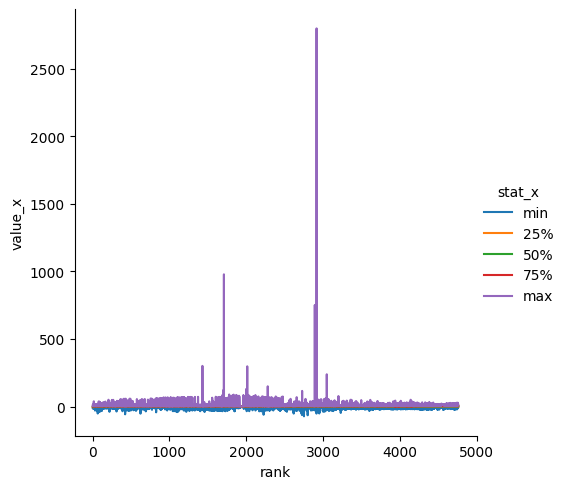

In [33]:
sns.relplot(
    stats_for_plot,
    x='rank',
    y='value_x',
    hue='stat_x',
    kind='line'
)

### 10 plate clustering

Let us normalize our 10 plates (each individually) and see (1) whether we see batch effects and (2) whether the controls cluster

In [34]:
normalized_profiles = annotated_profiles.groupby('Metadata_Plate').apply(
    pycytominer.normalize,
    # profiles is first positional argument
    features=list(feature_cols),
    image_features=True, # Include Image_### features
    method="standardize",
    samples="Metadata_Perturbation == 'CRISPR-no-guide'"
)#.reset_index('Metadata_Plate', drop=True)
normalized_profiles

Metadata_Source Metadata_Plate Metadata_Well   
Metadata_Plate                                                     
CP-CC9-R1-04   0          source_13   CP-CC9-R1-04           A01  \
               1          source_13   CP-CC9-R1-04           A02   
               2          source_13   CP-CC9-R1-04           A03   
               3          source_13   CP-CC9-R1-04           A04   
               4          source_13   CP-CC9-R1-04           A05   
...                             ...            ...           ...   
CP-CC9-R8-01   3449       source_13   CP-CC9-R8-01           P20   
               3450       source_13   CP-CC9-R8-01           P21   
               3451       source_13   CP-CC9-R8-01           P22   
               3452       source_13   CP-CC9-R8-01           P23   
               3453       source_13   CP-CC9-R8-01           P24   

                    Metadata_JCP2022              Metadata_Symbol   
Metadata_Plate                                                      
CP-CC9-R1-04   0      JCP2022_085227  SRVFFFJZQVENJC-UHFFFAOYSA-N  \
               1      JCP2022_800002                non-targeting   
               2      JCP2022_800073                      ABHD17A   
               3      JCP2022_804371                         MYL3   
               4      JCP2022_801649                      CYP4A11   
...                              ...                          ...   
CP-CC9-R8-01   3449   JCP2022_802274                         FASN   
               3450   JCP2022_800701                       ATP1A2   
               3451   JCP2022_802537                        G3BP1   
               3452   JCP2022_800001                     no-guide   
               3453   JCP2022_050797  LOUPRKONTZGTKE-UHFFFAOYSA-N   

                    Metadata_NCBI_Gene_ID Metadata_Perturbation   
Metadata_Plate                                                    
CP-CC9-R1-04   0                      NaN          Compound-trt  \
               1                      NaN  CRISPR-non-targeting   
               2                    81926            CRISPR-trt   
               3                     4634            CRISPR-trt   
               4                     1579            CRISPR-trt   
...                                   ...                   ...   
CP-CC9-R8-01   3449                  2194            CRISPR-trt   
               3450                   477            CRISPR-trt   
               3451                 10146            CRISPR-trt   
               3452                   NaN       CRISPR-no-guide   
               3453                   NaN          Compound-trt   

                     Cells_AreaShape_Area  Cells_AreaShape_BoundingBoxArea   
Metadata_Plate                                                               
CP-CC9-R1-04   0                -1.917751                        -1.887051  \
               1                -0.560074                        -0.511064   
               2                 0.571054                         0.584645   
               3                 1.691993                         1.858910   
               4                 4.609222                         4.917060   
...                                   ...                              ...   
CP-CC9-R8-01   3449              2.167788                         2.069231   
               3450              4.260001                         4.322785   
               3451              1.469158                         1.298771   
               3452             -0.649969                        -0.689682   
               3453             -0.765961                        -0.715612   

                     Cells_AreaShape_BoundingBoxMaximum_X  ...   
Metadata_Plate                                             ...   
CP-CC9-R1-04   0                                -0.185612  ...  \
               1                                -0.035814  ...   
               2                                 0.815215  ...   
               3    

In [35]:
perturbation_color_mapping = dict(zip(normalized_profiles.Metadata_Perturbation.unique(), sns.color_palette()))
plate_color_mapping = dict(zip(normalized_profiles.Metadata_Plate.unique(), sns.color_palette()))
#batch_color_mapping = dict(zip(annotated_profiles.Metadata_Batch.unique(), sns.color_palette()))

profile_annotation = normalized_profiles[['Metadata_Perturbation', 'Metadata_Plate']]
profile_annotation['Metadata_Perturbation'] = profile_annotation.Metadata_Perturbation.map(perturbation_color_mapping)
profile_annotation['Metadata_Plate'] = profile_annotation.Metadata_Plate.map(plate_color_mapping)

perturbation_color_mapping

/tmp/ipykernel_3236/3610746660.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_annotation['Metadata_Perturbation'] = profile_annotation.Metadata_Perturbation.map(perturbation_color_mapping)
/tmp/ipykernel_3236/3610746660.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_annotation['Metadata_Plate'] = profile_annotation.Metadata_Plate.map(plate_color_mapping)


{'Compound-trt': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'CRISPR-non-targeting': (1.0, 0.4980392156862745, 0.054901960784313725),
 'CRISPR-trt': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'CRISPR-no-guide': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392)}

In [36]:
from scipy.cluster.hierarchy import linkage

# Clustering linkages
linkage_data = {
    (method, metric): linkage(normalized_profiles[feature_cols], method=method, metric=metric)
    for method in ('average', 'single', 'complete')
    for metric in ('correlation', 'cosine', 'euclidean')
}

In [37]:
# Count Deviations from the zero-normalized mean
deviation_counts = pd.concat({
    f'>{x} SD': (normalized_profiles[feature_cols].abs() > x).sum(axis='columns')
    for x in [1, 1.5, 2, 2.5, 3]
}, axis='columns')

/tmp/ipykernel_3236/4269139102.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.figure.show()
/tmp/ipykernel_3236/4269139102.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.figure.show()
/tmp/ipykernel_3236/4269139102.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.figure.show()
/tmp/ipykernel_3236/4269139102.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.figure.show()
/tmp/ipykernel_3236/4269139102.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.figure.show()
/tmp/ipykernel_3236/

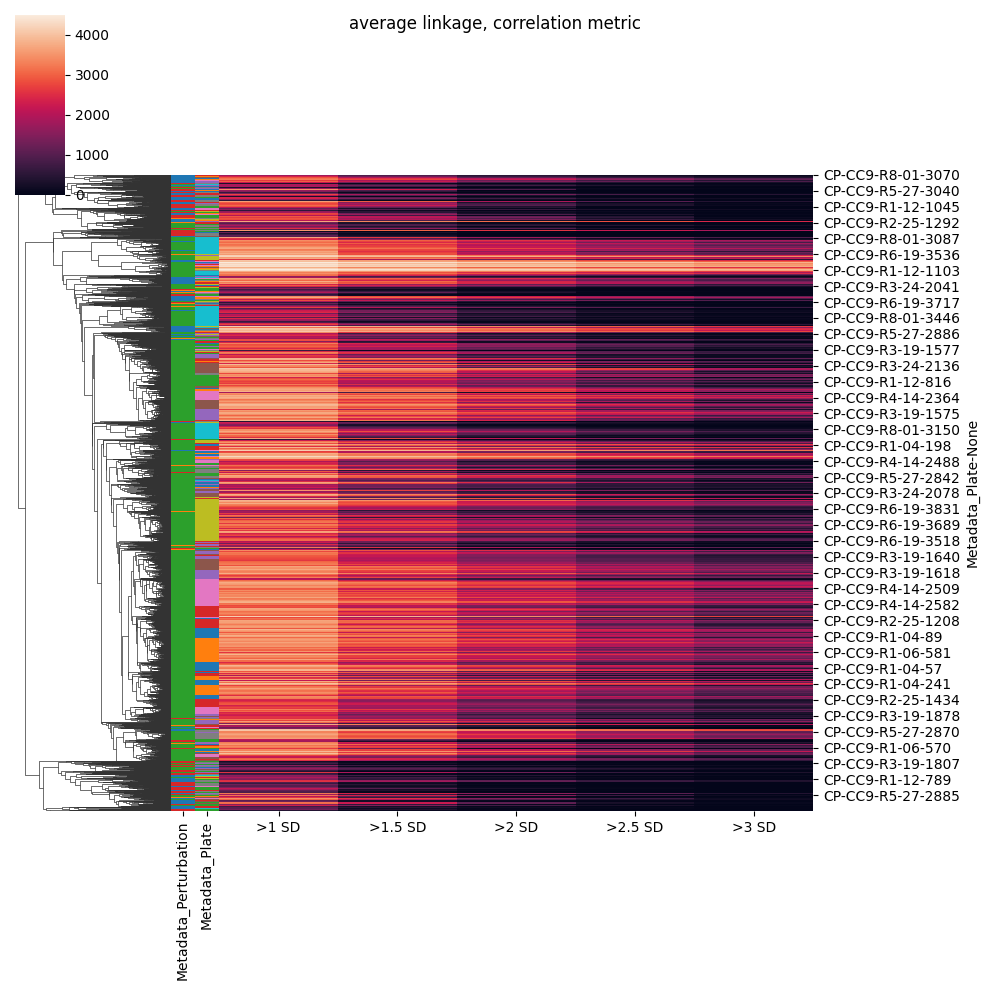

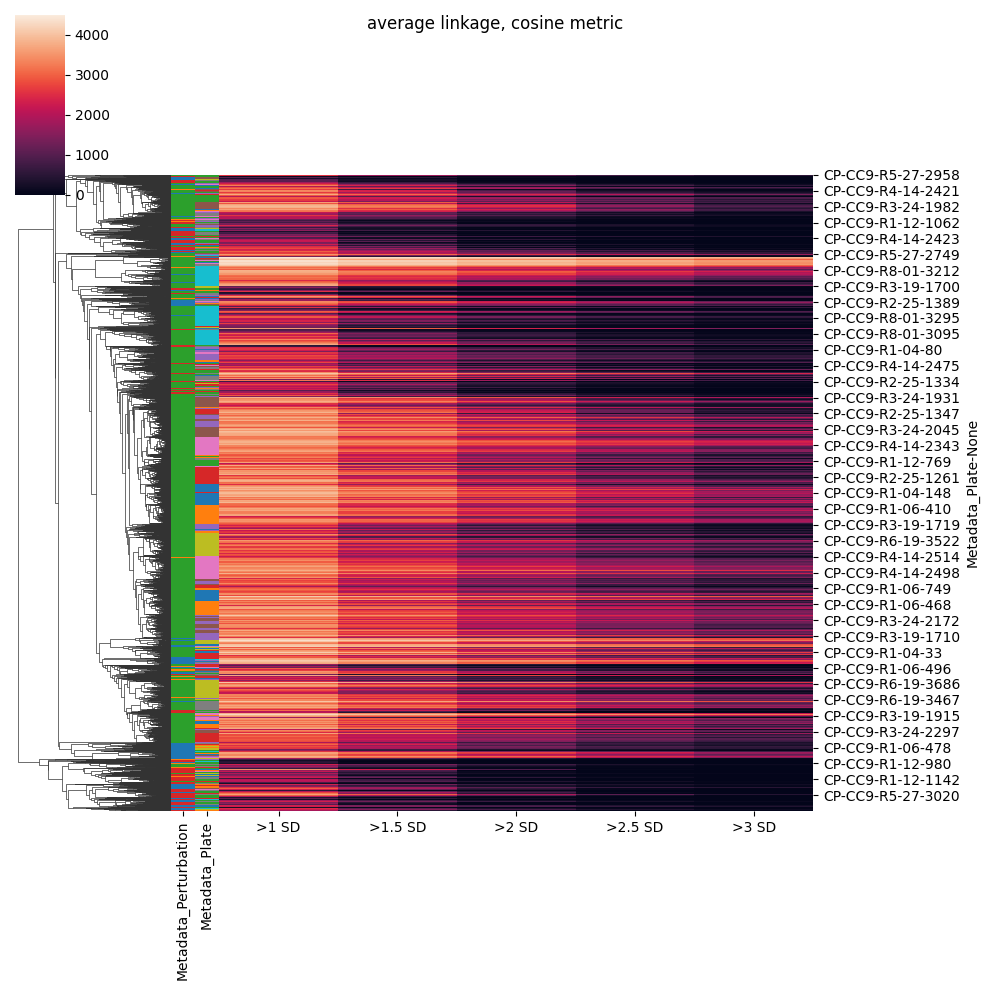

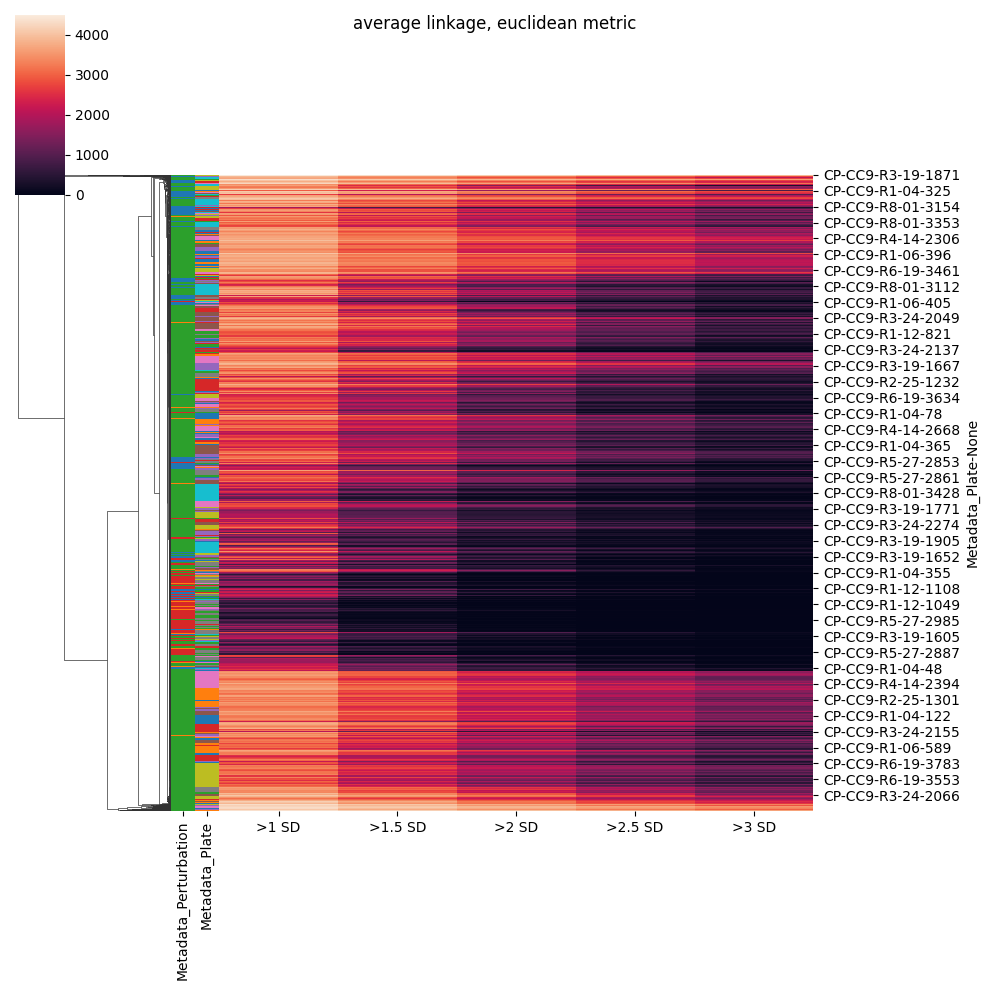

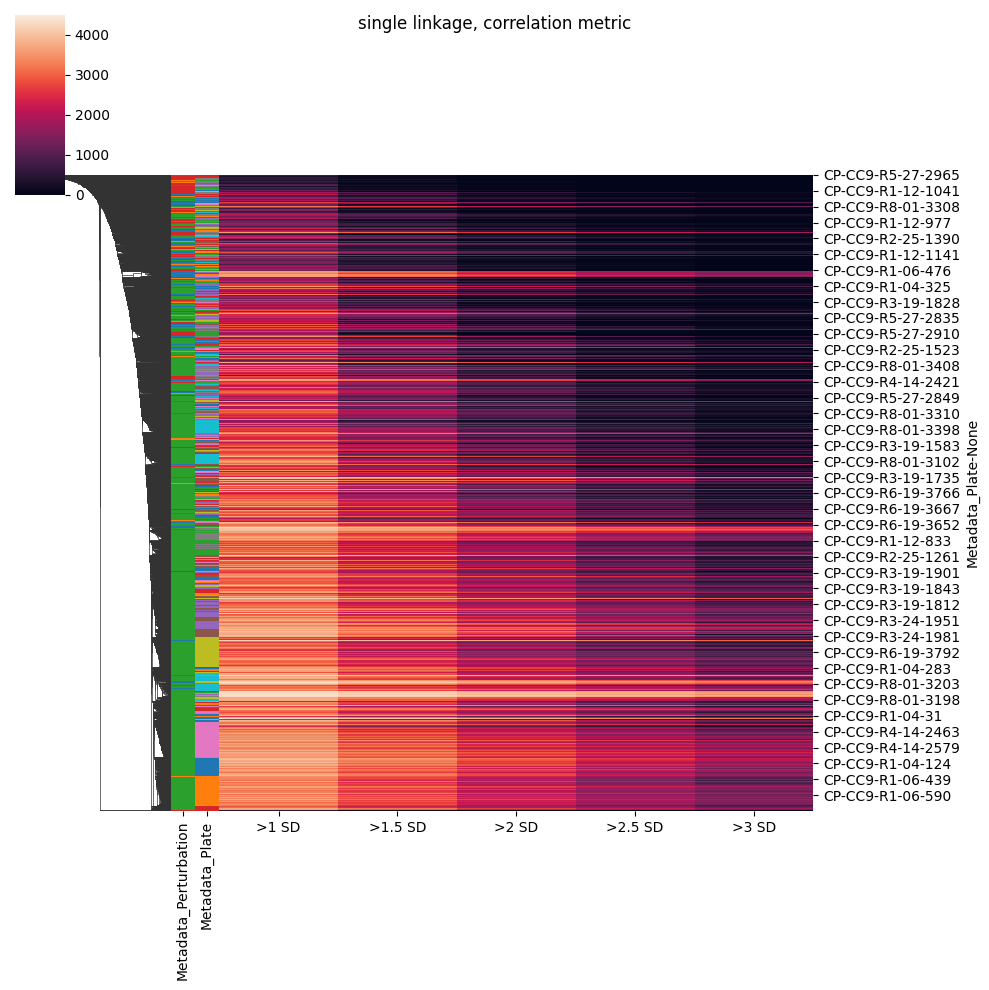

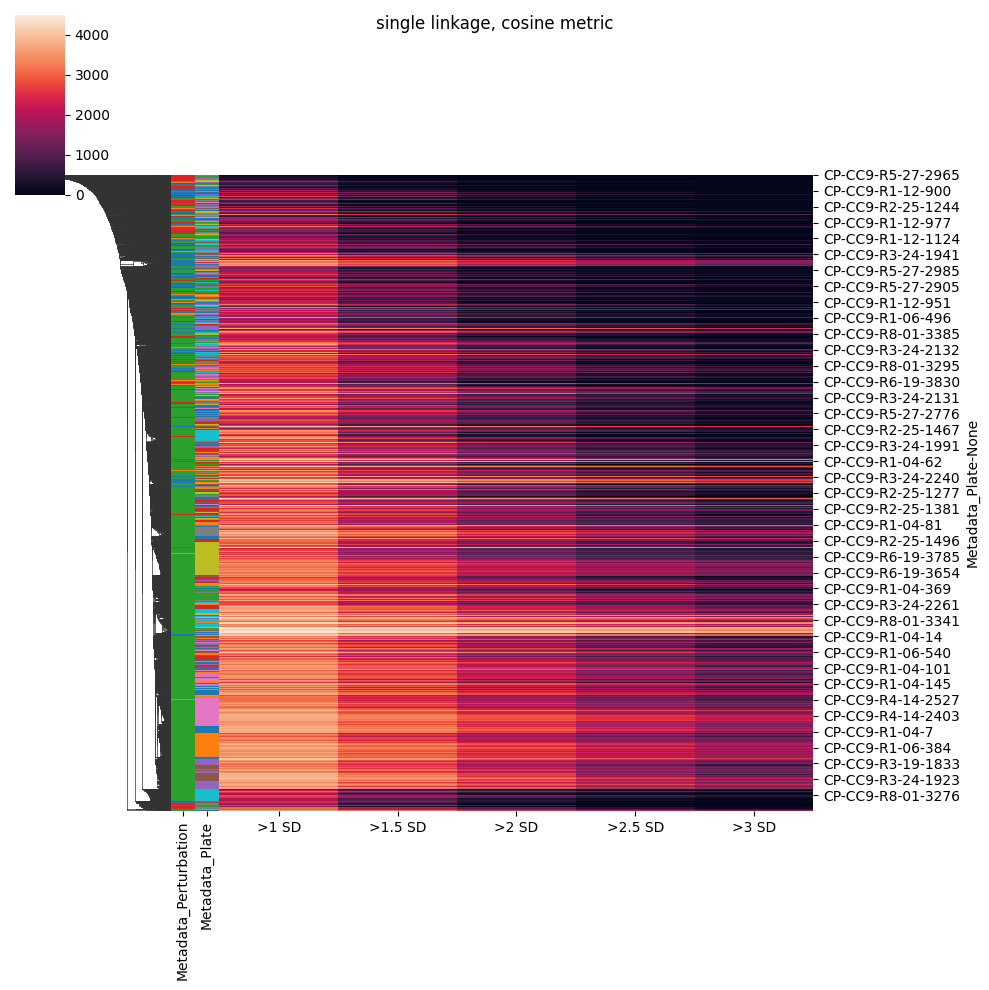

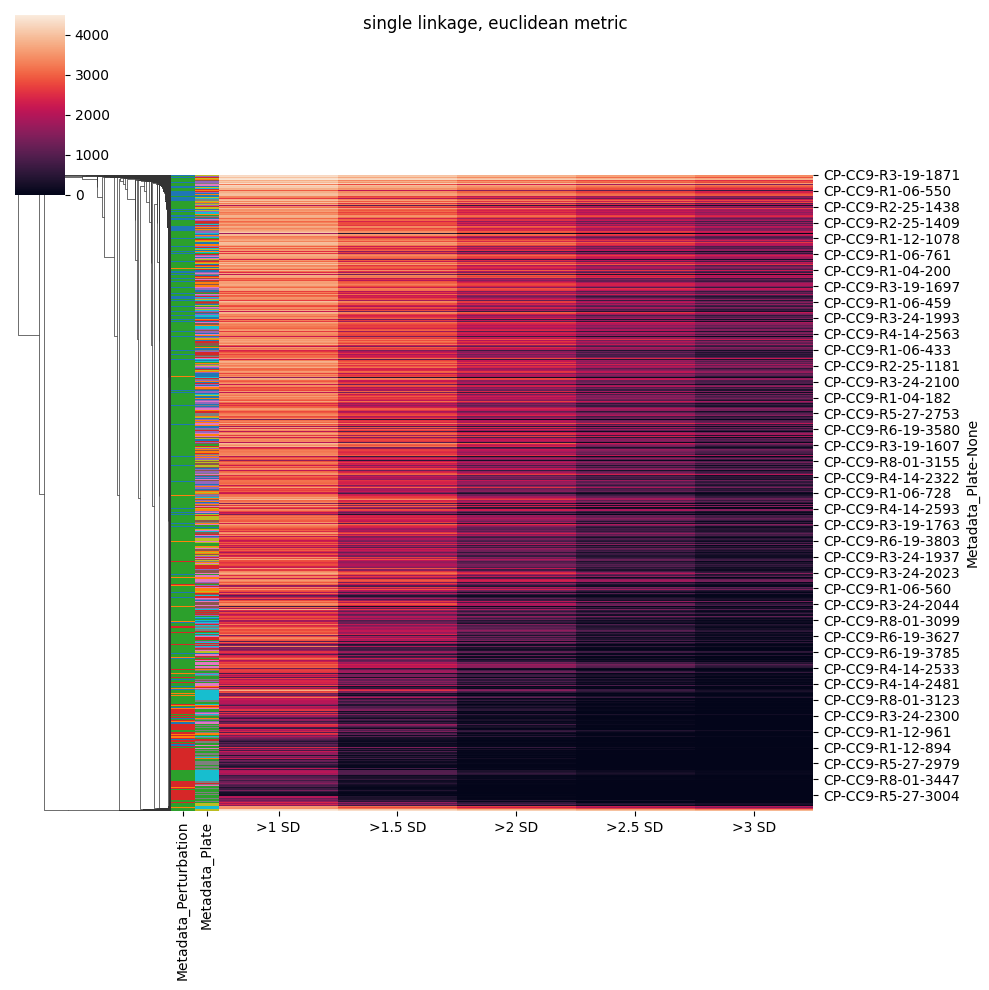

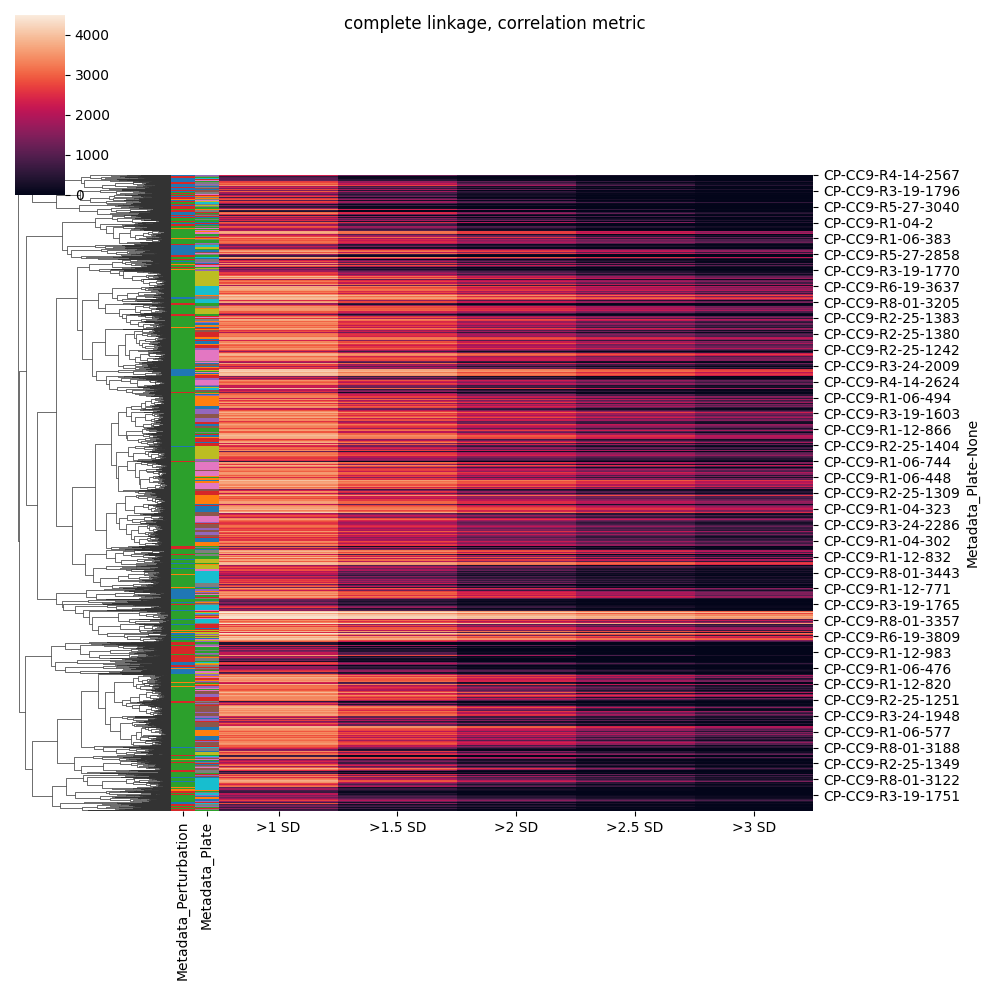

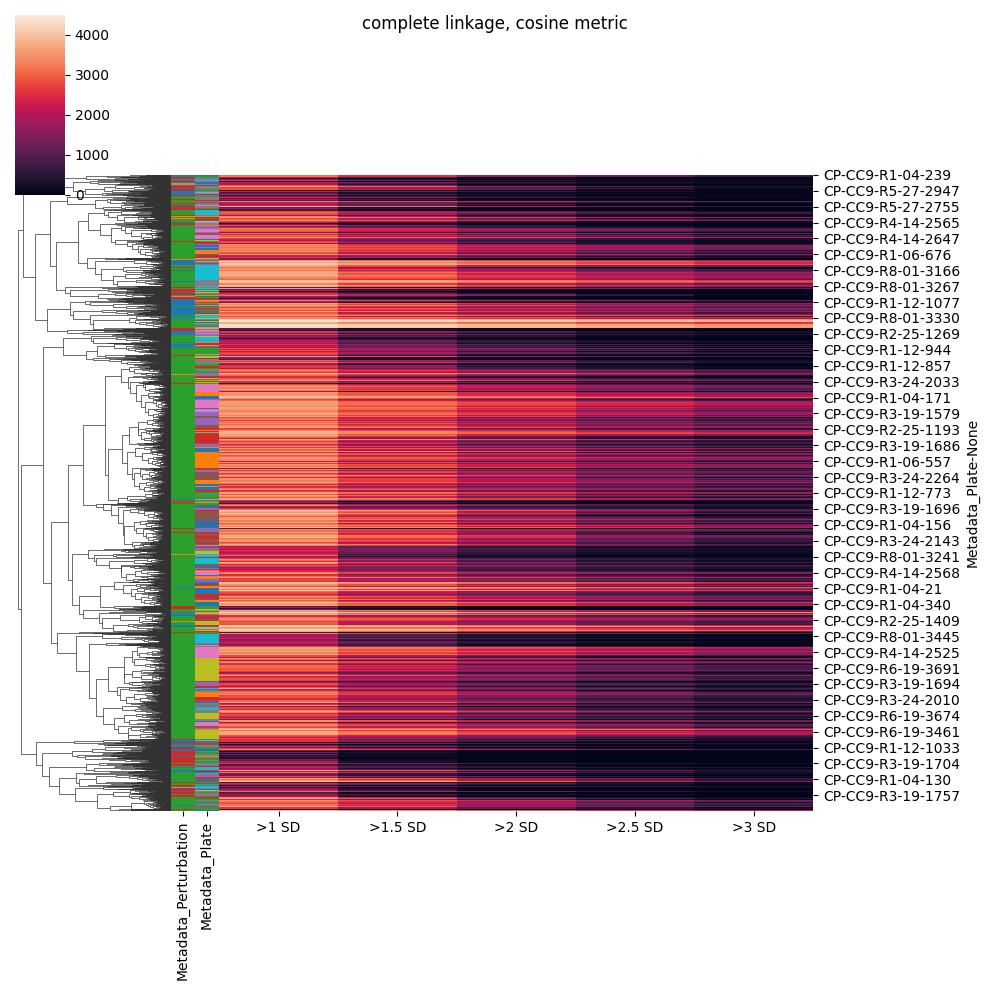

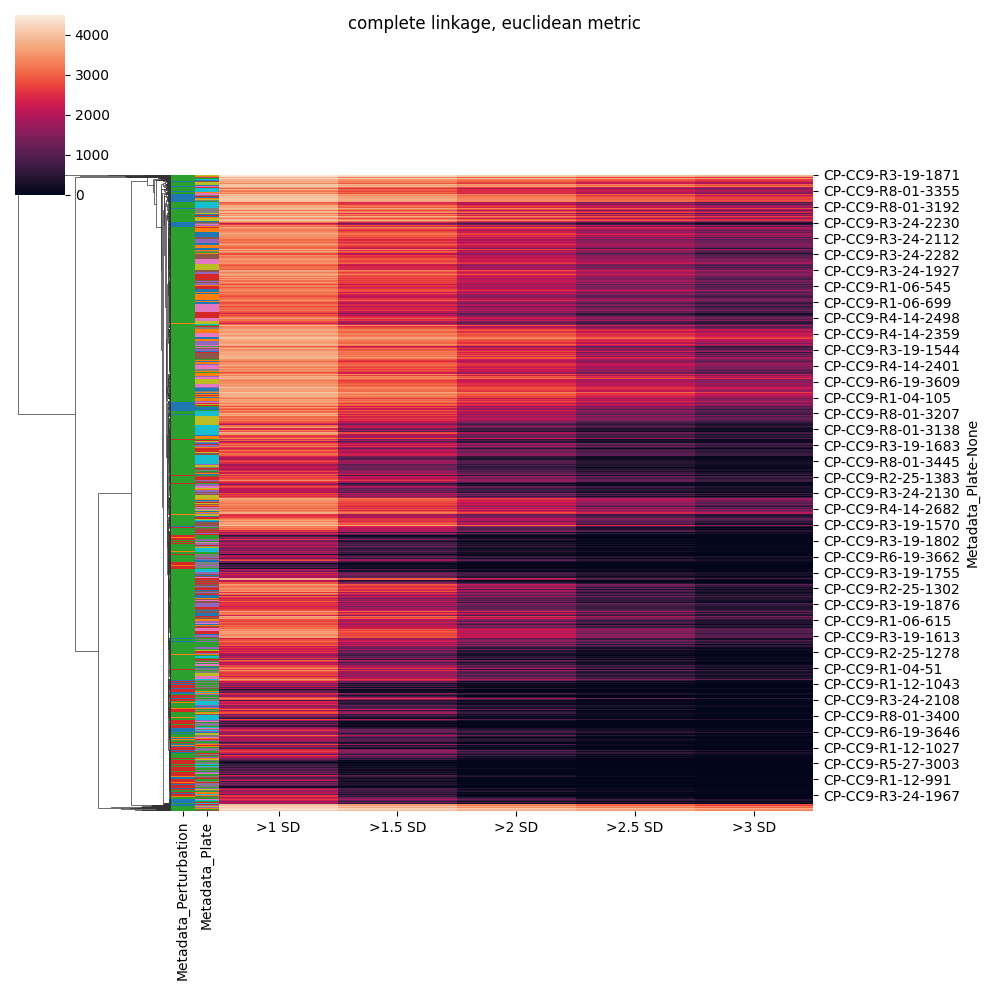

In [38]:
for (linkage_name, metric_name), linkage_obj in linkage_data.items():
    g = sns.clustermap(
        deviation_counts,
        row_colors=profile_annotation,
        row_linkage=linkage_obj,
        col_cluster=False
    )
    g.figure.suptitle(f'{linkage_name} linkage, {metric_name} metric')
    g.figure.show()

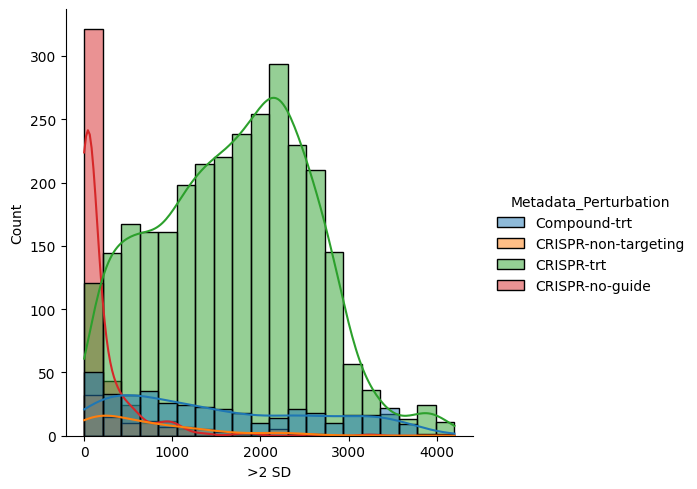

In [48]:
sd_counts_df = pd.concat([normalized_profiles[['Metadata_Perturbation', 'Metadata_Plate']], deviation_counts], axis='columns')

sns.displot(
    data=sd_counts_df,
    x='>2 SD',
    hue='Metadata_Perturbation',
    kde=True
)

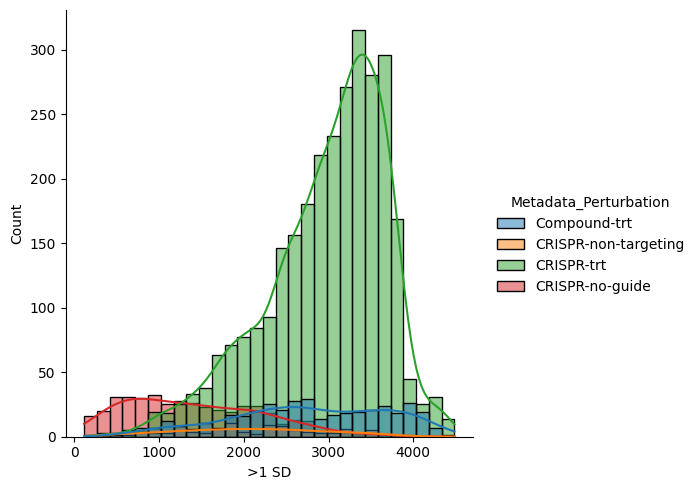

In [49]:
sns.displot(
    data=sd_counts_df,
    x='>1 SD',
    hue='Metadata_Perturbation',
    kde=True
)

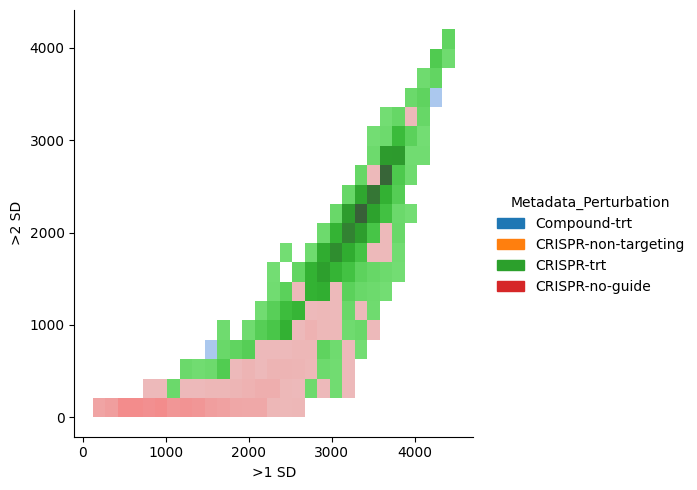

In [52]:
sns.displot(
    data=sd_counts_df,
    x='>1 SD',
    y='>2 SD',
    hue='Metadata_Perturbation',
    #kind='kde'
)

We are going to use a cutoff for +ve and -ve classification.

The idea:

+ve wells are all wells that fall above the threshold of Tp features >2 SD, where Tp is chosen such that fewer than 10% of the control wells fall within it.

-ve wells are all wells that fall below the threshold of Tn features >2 SD, where Tn is chosen such that 60% of control wells fall within it.

In [66]:
thresholds_df = sd_counts_df['>2 SD'].apply(
    lambda n: pd.concat([
        pd.Series({'Threshold': n}),
        sd_counts_df['Metadata_Perturbation'][sd_counts_df['>2 SD'] > n].value_counts() / sd_counts_df['Metadata_Perturbation'].value_counts()
    ])
)

threshold_col = thresholds_df['Threshold']
control_col = thresholds_df['CRISPR-non-targeting']

pt = threshold_col[control_col < 0.1].min()
nt = threshold_col[control_col > 0.4].max()

pt, nt

(1620.0, 644.0)

In [72]:
labeled_df = sd_counts_df.copy()
labeled_df['label'] = 'Indeterminate'
labeled_df.loc[sd_counts_df['>2 SD'] >= pt, 'label'] = 'Positive'
labeled_df.loc[sd_counts_df['>2 SD'] <= nt, 'label'] = 'Negative'
labeled_df[['Metadata_Perturbation', 'label']].value_counts()

Metadata_Perturbation  label        
CRISPR-trt             Positive         1592
                       Indeterminate     877
                       Negative          447
CRISPR-no-guide        Negative          391
Compound-trt           Positive          161
                       Indeterminate     120
                       Negative          119
CRISPR-non-targeting   Negative           59
                       Indeterminate      31
CRISPR-no-guide        Indeterminate      26
CRISPR-non-targeting   Positive           10
CRISPR-no-guide        Positive            5
Name: count, dtype: int64

Verification plots

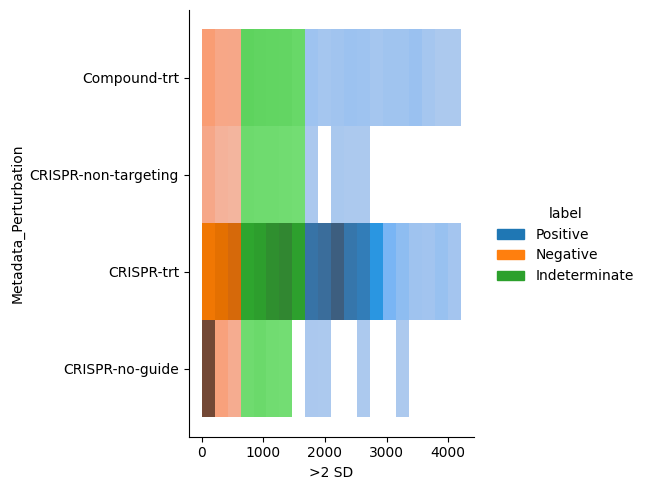

In [75]:
sns.displot(
    data=labeled_df,
    y='Metadata_Perturbation',
    x='>2 SD',
    hue='label',
    #kind='kde'
)

# Phenotype definition for full set

We use the above strategy to define a phenotype for the full set of CRISPR plates.

In [78]:
# Load profiles
crispr_set = plates[plates.Metadata_PlateType == 'CRISPR']
profiles = dd.read_parquet(
    [profile_uri_template.format_map(row) for _, row in crispr_set.iterrows()],
    storage_options={"anon": True}
)

In [81]:
# Merge with  metadata
annotated_profiles = profiles.merge(crispr_wells, how='left', on=['Metadata_Source', 'Metadata_Plate', 'Metadata_Well']).compute()

In [83]:
# Identify feature columns
numeric_profiles = annotated_profiles.select_dtypes(include='number')
feature_cols = numeric_profiles.columns[~numeric_profiles.columns.str.startswith('Metadata') & ~numeric_profiles.isna().any()]

In [84]:
# Get normalized profiles
normalized_profiles = annotated_profiles.groupby('Metadata_Plate').apply(
    pycytominer.normalize,
    # profiles is first positional argument
    features=list(feature_cols),
    image_features=True, # Include Image_### features
    method="standardize",
    samples="Metadata_Perturbation == 'CRISPR-no-guide'"
)

In [85]:
# Get SD counts
profiles_sd2 = (normalized_profiles[feature_cols].abs() > 2).sum(axis='columns')

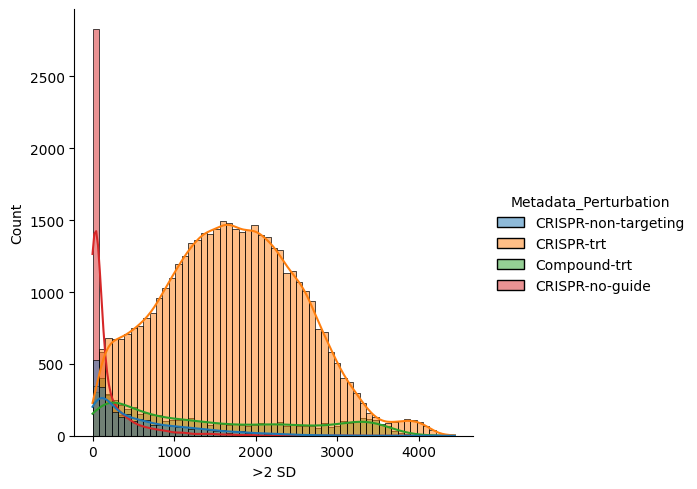

In [92]:
annotated_sd2 = normalized_profiles[['Metadata_Perturbation', 'Metadata_Plate']].copy()
annotated_sd2['>2 SD'] = profiles_sd2

sns.displot(
    data=annotated_sd2,
    x='>2 SD',
    hue='Metadata_Perturbation',
    kde=True
)

In [93]:
thresholds_df = profiles_sd2.apply(
    lambda n: pd.concat([
        pd.Series({'Threshold': n}),
        annotated_sd2['Metadata_Perturbation'][profiles_sd2 > n].value_counts() / annotated_sd2['Metadata_Perturbation'].value_counts()
    ])
)

threshold_col = thresholds_df['Threshold']
control_col = thresholds_df['CRISPR-non-targeting']

pt = threshold_col[control_col < 0.1].min()
nt = threshold_col[control_col > 0.4].max()

pt, nt

(1504.0, 549.0)

In [96]:
labeled_df = annotated_sd2.copy()
labeled_df['label'] = 'Indeterminate'
labeled_df.loc[profiles_sd2 >= pt, 'label'] = 'Positive'
labeled_df.loc[profiles_sd2 <= nt, 'label'] = 'Negative'
labeled_df[['Metadata_Perturbation', 'label']].value_counts()

Metadata_Perturbation  label        
CRISPR-trt             Positive         25345
                       Indeterminate    13902
                       Negative          4460
CRISPR-no-guide        Negative          4275
Compound-trt           Positive          2336
                       Negative          1856
CRISPR-non-targeting   Negative          1650
Compound-trt           Indeterminate     1444
CRISPR-non-targeting   Indeterminate      828
CRISPR-no-guide        Indeterminate      372
CRISPR-non-targeting   Positive           276
CRISPR-no-guide        Positive            77
Name: count, dtype: int64

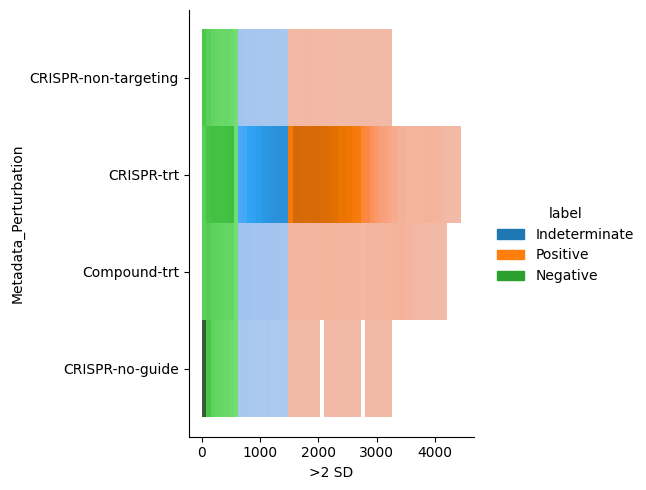

In [97]:
sns.displot(
    data=labeled_df,
    y='Metadata_Perturbation',
    x='>2 SD',
    hue='label',
    #kind='kde'
)

### Linking well levels to CRISPR KOs

In [108]:
labeled_metadata = pd.concat(
    [
        labeled_df.reset_index('Metadata_Plate', drop=True)['label'],
        annotated_profiles[
            annotated_profiles.columns[
                annotated_profiles.columns.str.startswith('Metadata')
            ]
        ]
    ],
    axis='columns'
)

In [113]:
# Deliverable #1: Labeled wells
labeled_metadata.to_csv('data/well_labels.csv', index=False)

In [117]:
labeled_crispr_trt = labeled_metadata[labeled_metadata['Metadata_Perturbation'] == 'CRISPR-trt']

labeled_crispr_genes = (
    labeled_crispr_trt
    .groupby(['Metadata_Symbol', 'Metadata_NCBI_Gene_ID'])
    .label
    .value_counts()
    .unstack('label', fill_value=0)
)
labeled_crispr_genes

,label,Indeterminate,Negative,Positive
Metadata_Symbol,Metadata_NCBI_Gene_ID,,,
A2M,2,2,1,2
A3GALT2,127550,3,0,2
A4GALT,53947,1,0,4
A4GNT,51146,4,0,2
AACS,65985,3,0,2
...,...,...,...,...
ZSCAN32,54925,4,0,1
ZSCAN4,201516,0,0,3
ZSCAN5A,79149,0,0,5


We need a rule to find "surely positive" and "surely negative" genes.
The approach we will take is to label by the majority.

In [122]:
pls = labeled_crispr_genes['Positive']
nls = labeled_crispr_genes['Negative']
ils = labeled_crispr_genes['Indeterminate']

final_labeled_crispr_genes = labeled_crispr_genes.copy()
final_labeled_crispr_genes['gene_label'] = 'Indeterminate'
final_labeled_crispr_genes['gene_label'][pls > nls + ils] = 'Positive'
final_labeled_crispr_genes['gene_label'][nls > pls + ils] = 'Negative'

final_labeled_crispr_genes.gene_label.value_counts()

/tmp/ipykernel_3236/3743650821.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_labeled_crispr_genes['gene_label'][pls > nls + ils] = 'Positive'
/tmp/ipykernel_3236/3743650821.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_labeled_crispr_genes['gene_label'][nls > pls + ils] = 'Negative'


gene_label
Positive         4558
Indeterminate    3064
Negative          353
Name: count, dtype: int64

In [123]:
# Deliverable #2: gene labels
final_labeled_crispr_genes.to_csv('data/gene_labels.csv')